In [286]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.cross_validation import train_test_split
from datetime import datetime, date, time
import re
import sklearn
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 150
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 3)
plt.rcParams['font.family'] = 'sans-serif'
import requests
from datetime import datetime
#from datetime import date
from numba import vectorize
import s2sphere as s2
#import datetime

In [287]:
def diff(first, second):
        second = set(second)
        return [item for item in first if item not in second]

# Грузим календарь

In [288]:
dates = pd.read_csv('calendar.csv', skiprows=1, index_col=0,
                    usecols=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],  
                    names=['year', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])

In [289]:
# предпраздничные дни
pre_holidays = []
# праздничне дни
holidays = []

for year in dates.index:
    for month in dates.columns:
        for day in dates.loc[year, month].split(','):
            if day.endswith('*'):
                pre_holidays.append(datetime(year, int(month), int(day[:len(day)-1]), 0, 0))
            else:
                holidays.append(datetime(year, int(month), int(day), 0, 0))
# transformate to pretty
def determ(date, hol, pre_hol):
    if date in hol:
        return 2#'h'
    elif date in pre_hol:
        return 1#'ph'
    else: return 0#'w'                

In [290]:
calendar = pd.DataFrame(data={
    'date': pd.date_range('1/1/2017', '12/31/2017', freq='D'),})
calendar['status'] = calendar['date'].apply(lambda x: determ(x, holidays, pre_holidays))
calendar['weekday'] = calendar['date'].apply(lambda x: x.weekday()) # понедельник - 0, воскресенье - 6

# Грузим города

In [291]:
city = pd.read_csv('t3.txt')

# Грузим дату

In [292]:
dtypes = {
    'transaction_date': str,
    'atm_address': str,
    'country': str,
    'city': str,
    'amount': np.float32,
    'currency': np.float32,
    'mcc': str,
    'customer_id': str,
    'pos_address': str,
    'atm_address': str,
    'pos_adress_lat': np.float32,
    'pos_adress_lon': np.float32,
    'pos_address_lat': np.float32,
    'pos_address_lon': np.float32,
    'atm_address_lat': np.float32,
    'atm_address_lon': np.float32,
    'home_add_lat': np.float32,
    'home_add_lon': np.float32,
    'work_add_lat': np.float32,
    'work_add_lon': np.float32,
}

In [293]:
test = pd.read_csv('test_set.csv', 
                 dtype = dtypes
                 #, nrows = 10000 
                 )

train = pd.read_csv('train_set.csv',
                 dtype = dtypes
                 #,nrows = 10000
                ).rename( columns={'pos_adress_lat':'pos_address_lat','pos_adress_lon':'pos_address_lon'}) 

submission = pd.DataFrame(test['customer_id'].unique(), columns = ['_ID_'])

train['is_train'] = np.int32(1)
test['is_train'] = np.int32(0)

df = pd.concat([train, test])
df = df.reset_index(drop=True)
del train, test

In [294]:
df['transaction_date'] = pd.to_datetime(df.transaction_date)
# удаляем транзакции без даты
df.drop(df[df['transaction_date'].isnull()].index, axis = 0, inplace = True) 

In [296]:
# Удаляем записи с путым терминалом
df.drop(df[df.terminal_id.isnull()].index, axis = 0, inplace = True)

In [297]:
df.drop(df[~((df.currency == 643)&((df.country == 'RUS')|(df.country == 'RU')))].index, axis = 0, inplace = True)

# Предобработка 

### Календарь + Координаты городов

In [298]:
df = df.merge(calendar, how='left', suffixes=('', '_c'), left_on = 'transaction_date',  right_on = 'date' ) 

df = df.merge(city.drop(['admin2','admin1'], axis= 1), how='left', suffixes=('', '_c'), 
                                                            left_on = 'city',  right_on = 'city' ) 
df.name.fillna('unknown', inplace=True)
del calendar, city

In [299]:
df = pd.get_dummies(df,columns=['status','weekday'])

##### Даты 

In [300]:
df['day'] = pd.DatetimeIndex(df['transaction_date']).day.astype(int)
#df['year'] = pd.DatetimeIndex(df['transaction_date']).year.astype(int)
df['month'] = pd.DatetimeIndex(df['transaction_date']).month.astype(int)
df.eval("cday = month*30 + day", inplace=True)

##### Подготовка

In [301]:
# очищаем mcc
df['mcc'] = df.mcc.str.replace(',', '').astype(int)
# очищаем currency
df['currency'] = df.currency.fillna(-1).astype(int)

In [302]:
df.loc[df.atm_address_lat > 0,'atm_char'] = df[df.atm_address_lat > 0]. \
  apply((lambda x: 2 if str(x.atm_address)[0] in "бвгджзйклмнпрстфхцчшщьъБВГДЖЗЙКЛМНПРСТФХЦЧШЩЬЪаоиеёэыуюяАОИЕЁЭЫУЮЯ" else 1), axis =1)

In [303]:
df['atm_char'] = df.atm_char.fillna(0).astype(int)
df = pd.get_dummies(df,columns=['atm_char'])    

In [304]:
df.fillna(0,inplace = True)

#### Сомнительные признаки

In [305]:
# Проставим Питер и Москву
df.loc[df.name == 'Moscow','fcity'] = 4 #Код moscow
df.loc[df.name == 'Saint Petersburg','fcity'] = 3 #Код st petersburg
df.loc[df.name == 'unknown','fcity'] = 2
df.loc[df.name == 'Takoradi','fcity'] = 1
df.fcity.fillna(0, inplace=True)

In [306]:
df.loc[~(((df.atm_address_lat>0) &(df.atm_address_lon>0))|
         ((df.pos_address_lat>0) &(df.pos_address_lon>0))),'empty'] = 1 #Нет адреса
df.loc[df.currency != 643,'cur643'] = 1 #Валюта не рубли
df.loc[(df.country != 'RUS') & (df.country != 'RU'),'counRU'] = 1 #Валюта не рубли
df.loc[df.mcc == 5921,'mcc5921'] = 1 #Код бара
df.loc[df.mcc == 5912,'mcc5912'] = 1 #Код аптеки 
df.loc[df.mcc == 7011,'mcc7011'] = 1 #Код Отели
df.loc[df.mcc == 5944,'mcc5944'] = 1 #Код украшения
df.loc[(df.mcc == 7512)|(df.mcc == 7513)|(df.mcc == 7519),'mcc7512'] = 1   #Код Заправки
df.loc[(df.mcc == 5812)|(df.mcc == 5813)|(df.mcc == 5814),'mcc5814'] = 1   #Код рестораны
df.loc[(df.mcc == 6010)|(df.mcc == 6011),'mcc6011'] = 1   #Cash
df.loc[(df.mcc >= 5960)&(df.mcc <= 5969),'mcc5969'] = 1   #Mail/Telephone/Preauth order
df.loc[(df.mcc == 6532)|(df.mcc == 6533)|(df.mcc == 6555),'mcc6533'] = 1   # Payment Services
df.loc[(df.mcc == 4829)|(df.mcc == 6050)|(df.mcc == 6051)|
       (df.mcc == 6529)|(df.mcc == 6530)|(df.mcc == 6534)|(df.mcc == 9754)|
       (df.mcc == 6539)|(df.mcc == 7511)|(df.mcc == 7995),'mcc4829'] = 1   # Unique
df.loc[(df.mcc == 5311)|(df.mcc == 5331)|(df.mcc == 5411)|(df.mcc == 5499),'mcc5311'] = 1   #Код Variety/Groc/Food Stores       
df.loc[(df.mcc == 7512)|(df.mcc == 7513)|(df.mcc == 7519),'mcc7519'] = 1   # Vehicle Rental
df.loc[(df.mcc < 999),'mcc999'] = 1


In [307]:
df.loc[df.mcc == 5921,'mcc_group'] = 1 #Код бара
df.loc[df.mcc == 5912,'mcc_group'] = 2 #Код аптеки 
df.loc[df.mcc == 7011,'mcc_group'] = 3 #Код Отели
df.loc[df.mcc == 5944,'mcc_group'] = 4 #Код украшения
df.loc[(df.mcc == 7512)|(df.mcc == 7513)|(df.mcc == 7519),'mcc_group'] = 5   #Код Заправки
df.loc[(df.mcc == 5812)|(df.mcc == 5813)|(df.mcc == 5814),'mcc_group'] = 6   #Код рестораны
df.loc[(df.mcc == 6010)|(df.mcc == 6011),'mcc_group'] = 7   #Cash
df.loc[(df.mcc >= 5960)&(df.mcc <= 5969),'mcc_group'] = 8   #Mail/Telephone/Preauth order
df.loc[(df.mcc == 6532)|(df.mcc == 6533)|(df.mcc == 6555),'mcc_group'] = 9   # Payment Services
df.loc[(df.mcc == 4829)|(df.mcc == 6050)|(df.mcc == 6051)|
       (df.mcc == 6529)|(df.mcc == 6530)|(df.mcc == 6534)|(df.mcc == 9754)|
       (df.mcc == 6539)|(df.mcc == 7511)|(df.mcc == 7995),'mcc_group'] = 10   # Unique
df.loc[(df.mcc == 5311)|(df.mcc == 5331)|(df.mcc == 5411)|(df.mcc == 5499),'mcc_group'] = 11   #Код Variety/Groc/Food Stores       
df.loc[(df.mcc == 7512)|(df.mcc == 7513)|(df.mcc == 7519),'mcc_group'] = 12   # Vehicle Rental
df.loc[(df.mcc < 999),'mcc_group'] = 13
df.loc[~(df.mcc_group > 0),'mcc_group'] = 0

In [308]:
df.loc[((df.atm_address_lat > 0) & (df.atm_address_lon > 0)),'atm'] = 1
df.loc[~((df.atm_address_lat > 0) & (df.atm_address_lon > 0)),'atm'] = 0
df.loc[((df.pos_address_lat > 0) & (df.pos_address_lon > 0)),'pos'] = 1
df.loc[~((df.pos_address_lat > 0) & (df.pos_address_lon > 0)),'pos'] = 0

#### Расчитываем расстояния и проставляем целевые метки для работы и дома

In [309]:
df['lat'] = df['atm_address_lat'].fillna(0) + df['pos_address_lat'].fillna(0)
df['lon'] = df['atm_address_lon'].fillna(0) + df['pos_address_lon'].fillna(0)

In [310]:
rad = 0.02 

df.eval("dw = ((work_add_lat-lat)**2 + (work_add_lon-lon)**2)** (0.5)", inplace=True)
df.eval("dh = ((home_add_lat-lat)**2 + (home_add_lon-lon)**2)** (0.5)", inplace=True)
df.dw.fillna(0, inplace=True)
df.dh.fillna(0, inplace=True)

df.loc[((df.dh <= rad) & (df.home_add_lat > 0)&(df.home_add_lon > 0)),'is_h'] = np.int32(1)
df.loc[~((df.dh <= rad)& (df.home_add_lat > 0)&(df.home_add_lon > 0)),'is_h'] = np.int32(0)

df.loc[((df.dw <= rad) & (df.work_add_lat > 0)&(df.work_add_lon > 0)),'is_w'] = np.int32(1)
df.loc[~((df.dw <= rad)& (df.work_add_lat > 0)&(df.work_add_lon > 0)),'is_w'] = np.int32(0)

In [311]:
df.eval("d_center = ((lat-pos_address_lat_c)**2 + (lon-pos_address_lon_c)**2)** (0.5)", inplace=True)
df.eval("sin_center = ((pos_address_lat_c-lat)**2)**(0.5)/d_center", inplace=True)

In [312]:
df['cityf'] = df['city'].factorize()[0].astype(np.int32)
df['countryf'] = df['country'].factorize()[0].astype(np.int32)

df['address'] = df['lat'].apply(lambda x: "%.02f" % x) + ';' + df['lon'].apply(lambda x: "%.02f" % x)
df['address'] = df['address'].factorize()[0].astype(np.int32)

### Пересчитаем координаты объектов рядом с домом/работой. 

In [313]:
delta = 0.005
rad2 = rad + delta
df.loc[((df.dh <= rad2)& (df.home_add_lat > 0)&(df.home_add_lon > 0)),'is_h2'] = np.int32(1)
df.loc[~((df.dh <= rad2)& (df.home_add_lat > 0)&(df.home_add_lon > 0)),'is_h2'] = np.int32(0)

df.loc[((df.dw <= rad2)& (df.work_add_lat > 0)&(df.work_add_lon > 0)),'is_w2'] = np.int32(1)
df.loc[~((df.dw <= rad2)& (df.work_add_lat > 0)&(df.work_add_lon > 0)),'is_w2'] = np.int32(0)

# Двигаем lat у Work
df.loc[(df.is_train == 1) & (df.is_w2==1) & (df.is_w==0) & (df.lat >= df.work_add_lat ), 'lat'] = \
 df[(df.is_train == 1) & (df.is_w2==1) & (df.is_w==0) & (df.lat >= df.work_add_lat )]. \
    eval("work_add_lat +(0.000225 - (work_add_lon-lon)**2)** (0.5)/2 ")
    
df.loc[(df.is_train == 1) & (df.is_w2==1) & (df.is_w==0) & ~(df.lat >= df.work_add_lat ), 'lat'] = \
 df[(df.is_train == 1) & (df.is_w2==1) & (df.is_w==0) & ~(df.lat >= df.work_add_lat )]. \
    eval("work_add_lat -(0.000225 - (work_add_lon-lon)**2)** (0.5)/2 ")    
    
# Двигаем lat у Home
df.loc[(df.is_train == 1) & (df.is_h2==1) & (df.is_h==0) & (df.lat >= df.home_add_lat ), 'lat'] = \
 df[(df.is_train == 1) & (df.is_h2==1) & (df.is_h==0) & (df.lat >= df.home_add_lat )]. \
    eval("home_add_lat +(0.000225 - (home_add_lon-lon)**2)** (0.5)/2 ")
    
df.loc[(df.is_train == 1) & (df.is_h2==1) & (df.is_h==0) & ~(df.lat >= df.home_add_lat ), 'lat'] = \
 df[(df.is_train == 1) & (df.is_h2==1) & (df.is_h==0) & ~(df.lat >= df.home_add_lat )]. \
    eval("home_add_lat -(0.000225 - (home_add_lon-lon)**2)** (0.5)/2 ") 
    
# Двигаем lon у Work
df.loc[(df.is_train == 1) & (df.is_w2==1) & (df.is_w==0) & (df.lon >= df.work_add_lon ), 'lon'] = \
 df[(df.is_train == 1) & (df.is_w2==1) & (df.is_w==0) & (df.lon >= df.work_add_lon )]. \
    eval("work_add_lon +(0.000225 - (work_add_lat-lat)**2)** (0.5)/2 ")
    
df.loc[(df.is_train == 1) & (df.is_w2==1) & (df.is_w==0) & ~(df.lon >= df.work_add_lon ), 'lon'] = \
 df[(df.is_train == 1) & (df.is_w2==1) & (df.is_w==0) & ~(df.lon >= df.work_add_lon )]. \
    eval("work_add_lon -(0.000225 - (work_add_lat-lat)**2)** (0.5)/2 ")    
    
# Двигаем lon у Home
df.loc[(df.is_train == 1) & (df.is_h2==1) & (df.is_h==0) & (df.lon >= df.home_add_lon ), 'lon'] = \
 df[(df.is_train == 1) & (df.is_h2==1) & (df.is_h==0) & (df.lon >= df.home_add_lon )]. \
    eval("home_add_lon +(0.000225 - (home_add_lat-lat)**2)** (0.5)/2 ")
    
df.loc[(df.is_train == 1) & (df.is_h2==1) & (df.is_h==0) & ~(df.lon >= df.home_add_lon ), 'lon'] = \
 df[(df.is_train == 1) & (df.is_h2==1) & (df.is_h==0) & ~(df.lon >= df.home_add_lon )]. \
    eval("home_add_lon -(0.000225 - (home_add_lat-lat)**2)** (0.5)/2 ")     

df.eval("dw = ((work_add_lat-lat)**2 + (work_add_lon-lon)**2)** (0.5)", inplace=True)
df.eval("dh = ((home_add_lat-lat)**2 + (home_add_lon-lon)**2)** (0.5)", inplace=True)
df.dw.fillna(0, inplace=True)
df.dh.fillna(0, inplace=True)

df.loc[((df.dh <= rad)& (df.home_add_lat > 0)&(df.home_add_lon > 0)),'is_h'] = np.int32(1)
df.loc[~((df.dh <= rad)& (df.home_add_lat > 0)&(df.home_add_lon > 0)),'is_h'] = np.int32(0)
df.loc[((df.dw <= rad)& (df.work_add_lat > 0)&(df.work_add_lon > 0)),'is_w'] = np.int32(1)
df.loc[~((df.dw <= rad)& (df.work_add_lat > 0)&(df.work_add_lon > 0)),'is_w'] = np.int32(0)    
print(df.query('(is_train == 1) & (is_w==1)').customer_id.nunique(),
      df.query('(is_train == 1) & (is_h==1)').customer_id.nunique())

3974 7957


### Генерируем категориальные признаки

###### Группа 'customer_id'

In [315]:
grouped = df.groupby('customer_id')
df['amount_sum'] = grouped['amount'].transform(lambda x: x.sum()) #процент от общей суммы на тразакцию
df.eval("amount_per = amount/amount_sum", inplace=True)
df['tx'] = grouped['amount'].transform(lambda x: x.count().astype(np.int32))
df.eval("amount_sqr = amount_sum/tx", inplace=True)
df['dday'] = grouped['cday'].transform(lambda x: x.rank())

df['lon_cus'] = grouped['lon'].transform(lambda x: x.median())
df['lat_cus'] = grouped['lat'].transform(lambda x: x.median())
df.eval("d_cus = ((lat-lat_cus)**2 + (lon-lon_cus)**2)** (0.5)", inplace=True)
df.eval("sin_cus = ((lat-lat_cus)**2)**(0.5)/d_cus", inplace=True)

##### Группа 'customer_id','address' 

In [316]:
grouped = df.groupby(['customer_id','address'])
df['amount_med'] = np.int32(0)
df['amount'] = df.amount.fillna(0)
df.loc[:,['amount_med','mcc_group','dday']] = grouped[['amount','mcc_group','dday']].transform(lambda x: x.median()) #процент от общей суммы на тразакцию
df.eval("amount_rm = amount/amount_med", inplace=True)

df['tx_cust_addr'] = grouped['amount'].transform(lambda x: x.count().astype(np.int32))
df['ratio'] = df['tx_cust_addr'] / df['tx']

In [318]:
cat = ['status_0','status_1','status_2','weekday_0','weekday_1',
         'weekday_2','weekday_3','weekday_4','weekday_5','weekday_6',
        'mcc5921','mcc5912','mcc7011','mcc5944','atm','pos','atm_char_0','atm_char_1','atm_char_2',
         'mcc7512','mcc5814','mcc6011','mcc5969','mcc6533','mcc4829','mcc5311','mcc7519','mcc999']
def get_sub(afield):
    for field in afield:
        df[field] = df[field] / df['tx_cust_addr']
        
df.loc[:,cat] = grouped[cat].transform(lambda x: x.sum()) #процент от общей на тразакцию
get_sub(cat)

In [319]:
df['amount_sum2'] = grouped['amount'].transform(lambda x: x.sum())
df['amount_sum3'] = df['amount_sum2'] / df['amount_sum']

In [322]:
df['cday_min'] = grouped['cday'].transform(lambda x: x.min().astype(np.int32))
df['cday_max'] = grouped['cday'].transform(lambda x: x.max().astype(np.int32))
df.eval("cday_per = (cday_max-cday_min)/tx_cust_addr", inplace=True)

##### Группа 'customer_id','mcc_group

In [323]:
grouped = df.groupby(['customer_id','mcc_group'])
df['lon_mcc'] = grouped['lon'].transform(lambda x: x.median())
df['lat_mcc'] = grouped['lat'].transform(lambda x: x.median())
df.eval("d_mcc = ((lat-lat_mcc)**2 + (lon-lon_mcc)**2)** (0.5)", inplace=True)
df.eval("sin_mcc = ((lat-lat_mcc)**2)**(0.5)/d_mcc", inplace=True)

df['cou_mcc'] = grouped['lon'].transform(lambda x: x.count())
df['mcc_ratio'] = df['cou_mcc'] / df['tx']

# Сократим выборку

In [324]:
df.drop(df[(~(df['pos_address_lat'] > 0) & ~(df['atm_address_lat'] > 0) & ~(df['is_train'] == 1))].index, axis = 0, inplace = True)
df.drop_duplicates(['customer_id','address'],inplace = True) 
df.shape

(488342, 98)

### Считаем квадраты 

In [325]:
def get_CellId(x):
    Cell = s2.CellId.from_lat_lng(s2.LatLng.from_degrees(x.lat, x.lon))
    x.CellId = Cell.id()
    x.Cell_p23_Id = Cell.parent(17).id()
    x.Cell_p20_Id = Cell.parent(12).id()
    x.Cell_p17_Id = Cell.parent(7).id()    
    x.Cell_pos = Cell.pos()
    x.Cell_siN = Cell.get_center_si_ti()[1]
    x.Cell_siT = Cell.get_center_si_ti()[2]
    x.Cell_uN = Cell.get_center_uv()[0]
    x.Cell_uT = Cell.get_center_uv()[1]
    return x

df['CellId'] = np.int32(0)
df['Cell_p23_Id'] = np.int32(0)
df['Cell_p20_Id'] = np.int32(0)
df['Cell_p17_Id'] = np.int32(0)
df['Cell_pos'] = np.int32(0)
df['Cell_siN'] = np.int32(0)
df['Cell_siT'] = np.int32(0)
df['Cell_uN'] = np.int32(0)
df['Cell_uT'] = np.int32(0)

df.loc[(df.lat > 0)&(df.lon > 0),:] = \
  df.query('(lat > 0)&(lon > 0)').apply((lambda x: get_CellId(x)), axis = 1 ) 

In [326]:
grouped = df.groupby(['CellId'])
df['CellId_g1'] = grouped['lon'].transform(lambda x: x.count())

In [327]:
grouped = df.groupby(['Cell_p23_Id'])
df['CellId_g2'] = grouped['lon'].transform(lambda x: x.count())
df['lon_cg2'] = grouped['lon'].transform(lambda x: x.median())
df['lat_cg2'] = grouped['lat'].transform(lambda x: x.median())
df.eval("d_cg2 = ((lat-lat_cg2)**2 + (lon-lon_cg2)**2)** (0.5)", inplace=True)
df.eval("sin_cg2 = ((lat-lat_cg2)**2)**(0.5)/d_cg2", inplace=True)

In [328]:
grouped = df.groupby(['Cell_p20_Id'])
df['CellId_g3'] = grouped['lon'].transform(lambda x: x.count())

df['lon_cg3'] = grouped['lon'].transform(lambda x: x.median())
df['lat_cg3'] = grouped['lat'].transform(lambda x: x.median())
df.eval("d_cg3 = ((lat-lat_cg3)**2 + (lon-lon_cg3)**2)** (0.5)", inplace=True)
df.eval("sin_cg3 = ((lat-lat_cg3)**2)**(0.5)/d_cg3", inplace=True)

In [329]:
grouped = df.groupby(['Cell_p17_Id'])
df['CellId_g4'] = grouped['lon'].transform(lambda x: x.count())

df['lon_cg4'] = grouped['lon'].transform(lambda x: x.median())
df['lat_cg4'] = grouped['lat'].transform(lambda x: x.median())
df.eval("d_cg4 = ((lat-lat_cg4)**2 + (lon-lon_cg4)**2)** (0.5)", inplace=True)
df.eval("sin_cg4 = ((lat-lat_cg4)**2)**(0.5)/d_cg4", inplace=True)

In [330]:
grouped = df.groupby(['customer_id','CellId'])
df['CellId_c1'] = grouped['lon'].transform(lambda x: x.count())

In [331]:
grouped = df.groupby(['terminal_id','CellId'])
df['CellId_t1'] = grouped['lon'].transform(lambda x: x.count())

##### Для центра города

In [332]:
grouped = df.groupby('name')
df['lon_cit'] = grouped['lon'].transform(lambda x: x.median()) #
df['lat_cit'] = grouped['lat'].transform(lambda x: x.median())
df.eval("d_cit = ((lat-lat_cit)**2 + (lon-lon_cit)**2)** (0.5)", inplace=True)
df.eval("sin_cit = ((lat_cit-lat)**2)**(0.5)/d_cit", inplace=True)

###### Группа 'customer_id' и 'quantile'

In [334]:
p25 = df.amount_sum3.quantile(0.25)
p75 = df.amount_sum3.quantile(0.75)
df.loc[df.amount_sum3 <= p25,'quantile'] = 0
df.loc[(df.amount_sum3 > p25)&(df.amount_sum3 <= p75),'quantile'] = 1
df.loc[df.amount_sum3 > p75,'quantile'] = 2

In [335]:
grouped = df.groupby(['customer_id','quantile'])
df['lon_qua'] = grouped['lon'].transform(lambda x: x.median())
df['lat_qua'] = grouped['lat'].transform(lambda x: x.median())
df.eval("d_qua = ((lat-lat_qua)**2 + (lon-lon_qua)**2)** (0.5)", inplace=True)
df.eval("sin_qua = ((lat-lat_qua)**2)**(0.5)/d_qua", inplace=True)

##### Группа 'terminal_id' (Помогает, но лучше оставить на потом)

In [336]:
#Считаем среднее расстояние по группе 'terminal_id'
grouped = df.groupby('terminal_id')
df['lon_ter'] = grouped['lon'].transform(lambda x: x.median())
df['lat_ter'] = grouped['lat'].transform(lambda x: x.median())
df.eval("d_ter = ((lat-lat_ter)**2 + (lon-lon_ter)**2)** (0.5)", inplace=True)
df.eval("sin_ter = ((lat-lat_ter)**2)**(0.5)/d_ter", inplace=True)

 # Уберем NaN и поправим типы

In [337]:
df.fillna(0,inplace = True)
#def col_to_int(acol):
#    for col in acol:
#        df[col] = df[col].astype(int)
#col_to_int(['is_h','is_w','atm','pos','fcity','empty','mcc4829','mcc5311','mcc5814','tx','quantile','tx_cust_addr',
#            'mcc5912','mcc5921','mcc5944','mcc5969','mcc6011','mcc6533',# 'is_fake_h', 'is_fake_w',
#            'mcc7011','mcc7512','mcc7519','mcc999','counRU','cur643','mcc_group','cou_mcc','atm_char_0',
#            'atm_char_1','atm_char_2',
#            'CellId_g1','CellId_g2','CellId_g3','CellId_g4','CellId_c1','CellId_t1','atm_char'])    

# Сохраним

In [356]:
#df.to_csv('super_df.csv', index=True, index_label='Index_name') # Добавил mcc групп

In [342]:
#df = pd.read_csv('super_df.csv', encoding = "ISO-8859-1")# Добавил mcc групп

# Учим Буст

In [344]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

In [345]:
column_future = ['currency','day','cday','fcity', 'mcc5921','mcc5912','mcc7011','mcc5944',
                 'mcc7512','mcc5814','mcc6011','mcc5969','mcc6533','mcc4829','mcc5311','mcc7519','mcc999',
                 'atm','pos','cityf','dday','d_cus','sin_cus', 'address','d_qua','sin_qua',
                 'd_cit','sin_cit','d_ter','sin_ter','ratio','amount_sqr','amount_per', 
                 'd_center','sin_center','d_mcc', 'sin_mcc', 'cou_mcc', 'mcc_ratio',
                 'atm_char_0','atm_char_1','atm_char_2','amount_sum3','CellId_g2','CellId_g3', 'CellId_g4',
                 'CellId_c1','CellId_g1','CellId_t1','d_cg3','sin_cg3','d_cg2','sin_cg2','d_cg4','sin_cg4',
                 'status_0',  'status_1',  'status_2','weekday_0', 'weekday_1',  'weekday_2', 'weekday_3',
                 'weekday_4', 'weekday_5',  'weekday_6', 'cday_min',  'cday_max',  'cday_per',  
                ]

In [346]:
params = {'max_depth': 30,
          'min_child_weight': 10, 
          'lambda': 0.01,   'alpha': 0.01,
          'eta': 0.1, 
          'objective': 'binary:logistic',
          'eval_metric' : 'auc',
          'silent': 1,     
          'seed': 17 , 'n_jobs' : 4       }

In [347]:
def teach_xgb(data, field_pred, data_test, plot = False):
    cust_train = df[df['is_train'] == 1].groupby('customer_id')['is_'+field_pred].max()
    cust_train = cust_train[cust_train > 0].index

    x_train, x_valid = train_test_split(cust_train, test_size = 0.3, random_state = 17)
    
    x_train = pd.DataFrame(x_train, columns = ['customer_id']).merge(df.query('is_train == 1')
                                                [column_future+['customer_id','is_h','is_w']], how = 'left')
    x_valid = pd.DataFrame(x_valid, columns = ['customer_id']).merge(df.query('is_train == 1')
                                                [column_future+['customer_id','is_h','is_w']], how = 'left')
    
    d_train = xgb.DMatrix(x_train[column_future], label=x_train['is_'+field_pred])
    d_valid = xgb.DMatrix(x_valid[column_future], label=x_valid['is_'+field_pred])

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    model1 = xgb.train(params, d_train, 100, watchlist, early_stopping_rounds=100, verbose_eval=10)
    
    d_train_full = xgb.DMatrix(data)
    df.loc[df.is_train == 1,'predict_'+field_pred]  = model1.predict(d_train_full)
    ret = df.query('is_train == 1').sort_values('predict_'+field_pred, ascending=False).drop_duplicates(['customer_id'])
    print('Вероятность (%) = ',round(len(ret.query('is_'+field_pred+'==1'))/len(ret)*100,2))
    
    d_train_full = xgb.DMatrix(data_test)
    df.loc[df.is_train == 0,'predict_test'+field_pred]  = model1.predict(d_train_full)
    ret = df.query('is_train == 0').sort_values('predict_test'+field_pred, ascending=False).drop_duplicates(['customer_id'])
    
    if plot:
        my_plot_importance(model1, (10,20))
    
    return ret

[0]	train-auc:0.941969	valid-auc:0.847633
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[10]	train-auc:0.972488	valid-auc:0.886772
[20]	train-auc:0.980363	valid-auc:0.892862
[30]	train-auc:0.986965	valid-auc:0.895053
[40]	train-auc:0.991751	valid-auc:0.896703
[50]	train-auc:0.995065	valid-auc:0.897856
[60]	train-auc:0.997226	valid-auc:0.898533
[70]	train-auc:0.998364	valid-auc:0.898982
[80]	train-auc:0.999019	valid-auc:0.898851
[90]	train-auc:0.999432	valid-auc:0.898443
[99]	train-auc:0.999686	valid-auc:0.898245
Вероятность (%) =  36.51


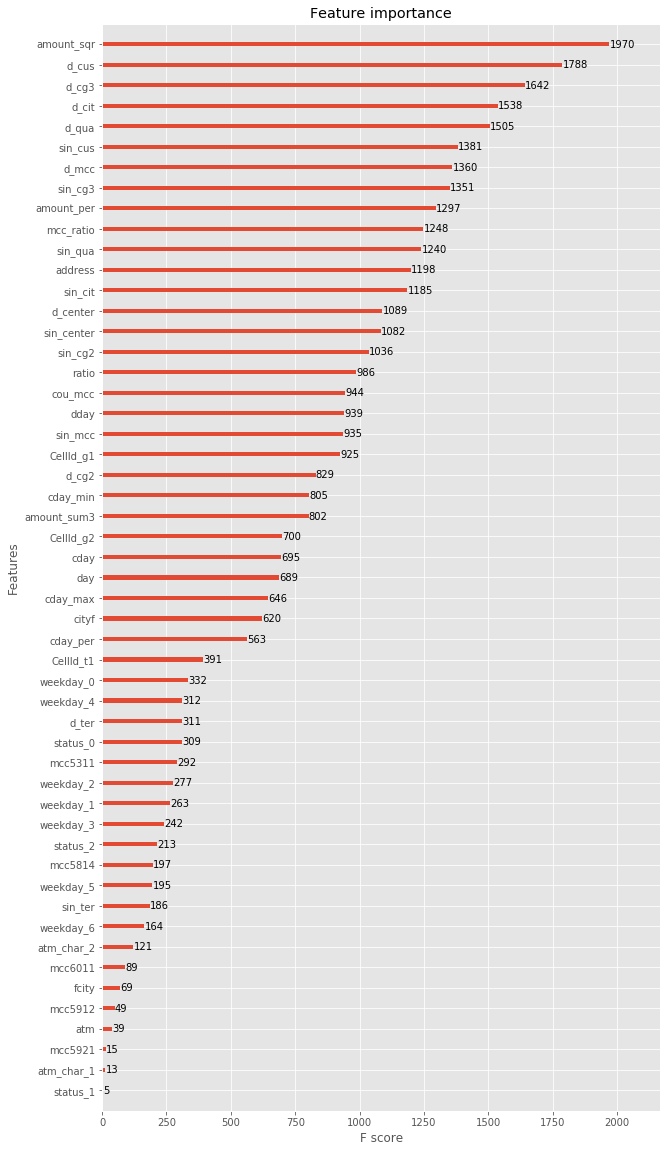

In [348]:
ret_w = teach_xgb(df.query('is_train == 1')[column_future],'w', df.query('is_train == 0')[column_future], True)

[0]	train-auc:0.936264	valid-auc:0.863008
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[10]	train-auc:0.966964	valid-auc:0.897175
[20]	train-auc:0.976445	valid-auc:0.902651
[30]	train-auc:0.98405	valid-auc:0.905011
[40]	train-auc:0.99017	valid-auc:0.906128
[50]	train-auc:0.994172	valid-auc:0.906266
[60]	train-auc:0.996699	valid-auc:0.906849
[70]	train-auc:0.998182	valid-auc:0.906505
[80]	train-auc:0.998928	valid-auc:0.906418
[90]	train-auc:0.999407	valid-auc:0.906395
[99]	train-auc:0.999664	valid-auc:0.906397
Вероятность (%) =  73.68


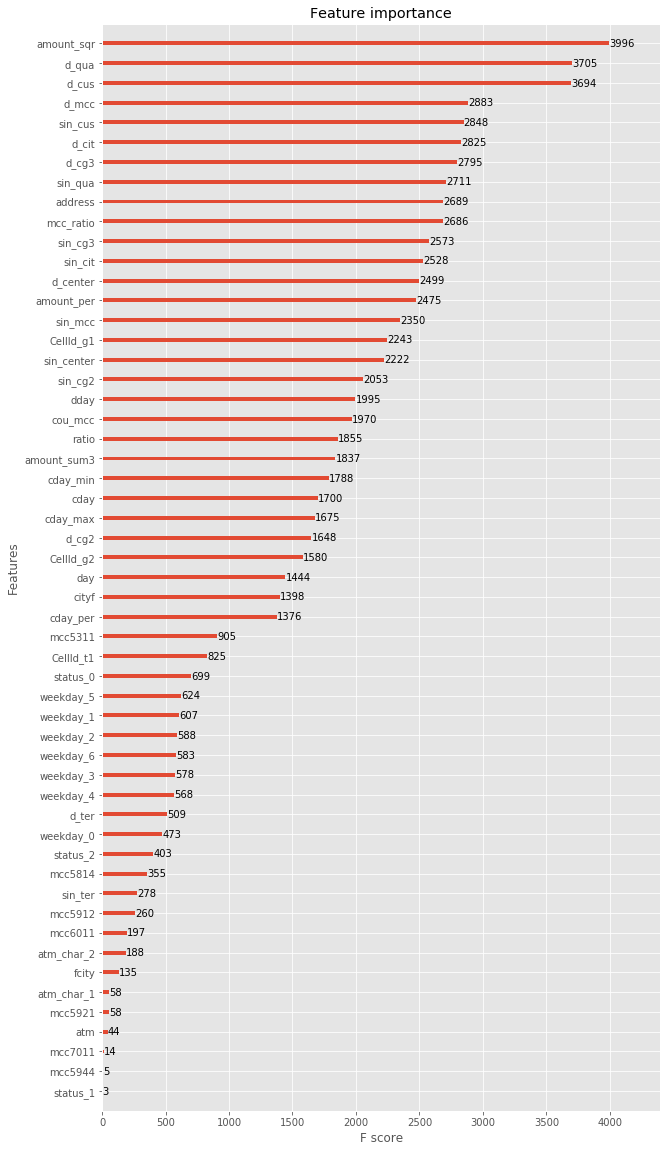

In [350]:
ret_h = teach_xgb(df.query('is_train == 1')[column_future],'h', df.query('is_train == 0')[column_future], True)

# Сабмит

In [351]:
columns_my = ['customer_id','lat_w','lon_w', 'lat_h', 'lon_h']
columns_sempl = ['_ID_', '_WORK_LAT_', '_WORK_LON_', '_HOME_LAT_', '_HOME_LON_']
result = pd.merge(ret_w,ret_h,how='inner', on='customer_id', suffixes=('_w', '_h') )[columns_my]
result.rename(columns=dict(zip(columns_my, columns_sempl))).to_csv('answ.csv', index=False)

# Проверка

In [352]:
import pandas as pd
import numpy as np

def check_submit(path_to_csv):
    df = pd.read_csv(path_to_csv)
    assert df.shape == (9997, 5), u'Мало или много строк'
    assert list(df.columns) == ['_ID_', '_WORK_LAT_', '_WORK_LON_', '_HOME_LAT_', '_HOME_LON_'], u'Неверные названия столбцов'
    assert np.any(df['_ID_'].duplicated()) == False, u'Одному клиенту соответствует больше одной записи'
    for col_name in df.columns:
        if col_name != '_ID_':
            assert df[col_name].dtype in (np.float, np.int), u'В колонке {col_name} есть NULL'.format(col_name=col_name)
        assert df[col_name].isnull().sum() == 0, u'В колонке {col_name} есть NULL'.format(col_name=col_name)

In [353]:
check_submit('answ.csv')